In [3]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

from mtr.config import cfg, cfg_from_yaml_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC
from tqdm import tqdm
import numpy as np

cfg_file = 'tools/cfgs/waymo/bc+10_percent_data.yaml'
cfg = cfg_from_yaml_file(cfg_file, cfg)
cfg.DATA_CONFIG.WITHOUT_HDMAP = True
dataset = WaymoDatasetBC(cfg.DATA_CONFIG, training=True)
num_data = len(dataset)

# Calculate Mean and STD without resampling

In [ ]:
def calc(n, running_sum, running_sum_square):
    mean  = running_sum / n
    var = running_sum_square / n - mean**2
    std = var**0.5
    
    print('mean: ', mean)
    print('var: ', var)
    print('std: ', std)
    return mean, var, std

In [ ]:
running_sum = 0
running_sum_square = 0
n = 0
max = 0

for i in tqdm(range(num_data)):
    scene_id, info = dataset.load_info(i)
    for t in range(10, 90, 10):
        data = dataset.extract_scene_data(scene_id, info, t)
        if data is None:
            continue
        gt = data['center_gt'][...,:3]
        running_sum += gt.sum(axis=0)
        running_sum_square += (gt**2).sum(axis=0)
        n += gt.shape[0]
        batch_max = np.abs(gt).max(axis=0)
        
        max = np.maximum(batch_max, max)
    if i%500 == 0:    
        print(f'itr: {i}, max: {max}')
        mean, var, std = calc(n, running_sum, running_sum_square)
    
mean, var, std = calc(n, running_sum, running_sum_square)


# Analysis data distribution

In [15]:
mean = np.array([7.26195561e-01, 1.52434988e-03, 7.25015970e-04])
std = np.array([0.54773382, 0.02357974, 0.04607823])

x_histogram = None
y_histogram = None
h_histogram = None

In [24]:
for i in tqdm(range(num_data)):
    scene_id, info = dataset.load_info(i)
    for t in range(10, 90, 10):
        data = dataset.extract_scene_data(scene_id, info, t)
        if data is None:
            continue
        gt = data['center_gt'][...,:3]
        gt_normalized = (gt - mean) / std
        batch_histogram_x = np.histogram(gt_normalized[...,0], bins=100, range=(-5, 5))[0]
        batch_histogram_y = np.histogram(gt_normalized[...,1], bins=100, range=(-5, 5))[0]
        batch_histogram_h = np.histogram(gt_normalized[...,2], bins=100, range=(-5, 5))[0]
        if x_histogram is None:
            x_histogram = batch_histogram_x
            y_histogram = batch_histogram_y
            h_histogram = batch_histogram_h
            
        else:
            x_histogram += batch_histogram_x
            y_histogram += batch_histogram_y
            h_histogram += batch_histogram_h
                    

100%|██████████| 48821/48821 [09:26<00:00, 86.21it/s] 


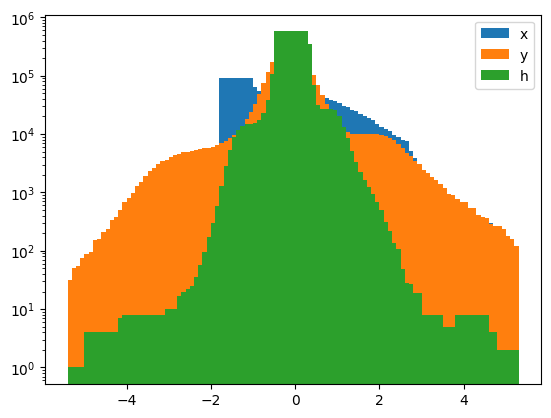

In [28]:
# Plot histogram
import matplotlib.pyplot as plt 
plt.bar(np.arange(-5, 5, 0.1), x_histogram, label='x')
plt.bar(np.arange(-5, 5, 0.1), y_histogram, label='y')
plt.bar(np.arange(-5, 5, 0.1), h_histogram, label='h')
plt.yscale('log')

plt.legend()